# Servo simulation draft

Outline for simulating response from two-level ion when driven with a drifting clock laser. Linewidth functions interchangeable.

TODO:
- integrate dead time ($e^{-(t_{meas}/\tau_{ion})}$)
- laser noise & linewidth
- some way to simulate different measurement cycles (LHHL), maybe add an impact on dead time due to servo re-alignment?

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import peak_widths, find_peaks
from scipy.stats import cauchy, binom
import allantools
import sys
sys.path.append('./')
from simul_utils import lineshape, k_p, allan_deviation, sampling_cycle, FWHM

ImportError: cannot import name 'sampled_lineshape' from 'simul_utils' (C:\data\simulation\simul_utils.py)

Lineshape function used is the ideal Rabi flopping when driven with pi pulses:
\begin{align}
\rho_{ee}(t) = \left( \frac{\pi}{2} \right)^2 \textrm{sinc}^2 \left( \frac{\sqrt{\pi^2 + \delta^2 t^2}}{2} \right)
\end{align} 

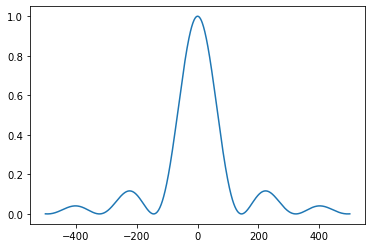

In [2]:
d, step = np.linspace(-500, 500, 1000, retstep=True)
plt.plot(d, lineshape(d, 6e-3, True))

The slope ($k_p(\delta, t)$) is calculated using a simple finite differential scheme from the disciminant function. More sophisticated methods could also be used.

The disciminant function $\kappa$ is constructed by sliding the laser offset across the peak and calculating the resulting gainless error signal. $k_p$ is then the slope of the disciminant evaluated at $\delta=0$.
\begin{align}
\kappa(\delta) &= p_B(\delta) - p_R(\delta) \\
k_p &= \left.\frac{d \kappa(\delta)}{d\delta}\right\vert_{\delta = 0}
\end{align}

-0.02276504626112354

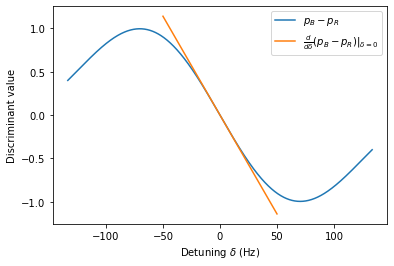

In [3]:
d, step = np.linspace(-200, 200, 10000, retstep=True)
kp, d_k, d = k_p(lineshape, d, 6e-3, state_prep=True)
plt.plot(d, d_k, label=r"$p_B - p_R$")
d_kp = np.linspace(-50, 50, 100)
tangent = d_kp * kp
plt.plot(d_kp, tangent, label=r"$\frac{d}{d \delta}(p_B - p_R)|_{\delta=0}$")
plt.legend()
plt.xlabel(r"Detuning $\delta$ (Hz)")
plt.ylabel("Discriminant value")
kp

Visualising the result of laser offset on the measured probabilities $p_R$ and $p_B$. Scipy ``peak_widths`` used here to calculate FWHM.

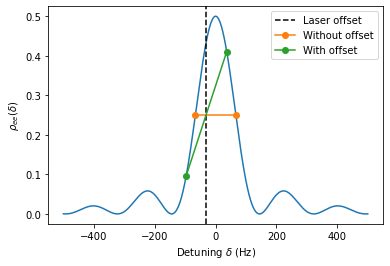

In [4]:
def get_both_ps(d, lineshape_func, t, laser_offset=None):
    l_s =lineshape_func(d, t) # generate lineshape data
    widths = peak_widths(l_s, [np.argmax(l_s)], rel_height=0.5) #get FWMH data
    x_R = d[int(np.rint(widths[2][0]))]
    x_B = d[int(np.rint(widths[3][0]))]
    p_R = p_B = widths[1][0]
    if laser_offset is not None:
        x_R += laser_offset
        x_B += laser_offset
        p_R = lineshape_func(x_R, t)
        p_B = lineshape_func(x_B, t)
    return {'x_R': x_R,
            'x_B': x_B,
            'p_R': p_R,
            'p_B': p_B}

d, step = np.linspace(-500, 500, 1000, retstep=True)
l_s = lineshape(d, 6e-3)
widths = peak_widths(l_s, [np.argmax(l_s)], rel_height=0.5)
without_offset = get_both_ps(d, lineshape, 6e-3)
laser_offset = -30
with_offset = get_both_ps(d, lineshape, 6e-3, laser_offset=laser_offset)
plt.plot(d, l_s)
plt.axvline(laser_offset, color='k', linestyle='--', label='Laser offset')
plt.plot([without_offset['x_R'], without_offset['x_B']],[without_offset['p_R'], without_offset['p_B']], marker='o', label='Without offset')
plt.plot([with_offset['x_R'], with_offset['x_B']],[with_offset['p_R'], with_offset['p_B']], marker='o', label='With offset')
plt.xlabel(r"Detuning $\delta$ (Hz)")
plt.ylabel(r"$\rho_{ee}(\delta)$")
plt.legend()

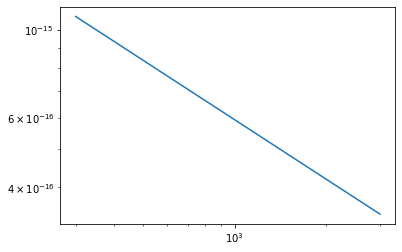

In [5]:
tau_pi = 6e-3 # s, pulse length
T_c = 2*tau_pi # s, single cycle length
d, step = np.linspace(-200, 200, 100000, retstep=True)
kp, _, _ = k_p(lineshape, d, tau_pi)
taus = np.linspace(300, 3000, 100)
f0 = 444779044095486.5 # Hz, Sr88 SRS
adev = allan_deviation(0.25, kp, f0, T_c, taus)
plt.plot(taus, adev)
plt.xscale("log")
plt.yscale("log")

In [11]:
T_s = 5 #s
n_m = 100 #number of measurements per cycle
d, step = np.linspace(-500, 500, 1000, retstep=True)
l_s = lineshape(d, 6e-3)
sampling_cycle(0, T_s, 100, FWHM(l_s, d)/2, 6e-3)

(0.21, 9.900000000584441e-05, 0.0001)

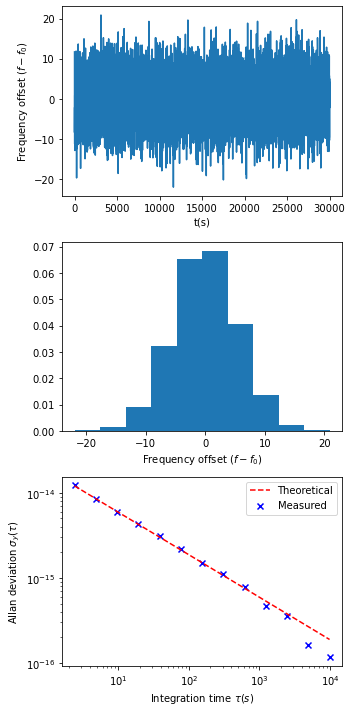

In [8]:
# main simulation loop
n_s = 100 # number of samples
tau_pi = 6e-3 # s, pulse length
T_c = 2*tau_pi # s, single cycle length
T_s = n_s * T_c
initial_offset = 0 # Hz
state_preparation = False
max_tau = 30000 # s, max integration time
n_c = 2 # number of cycles per correction
laser_drift = 20e-3 # Hz/s
f0 = 444779044095486.5 # Hz, Sr88 SRS
t = np.arange(start=T_c, stop=max_tau, step=n_c*T_s)
eta_cavity = np.zeros(len(t)) # cavity frequency
eta_corrected = np.zeros(len(t)) # servo-corrected frequency
d, step = np.linspace(-200, 200, 100000, retstep=True)
kp, _, _ = k_p(lineshape, d, tau_pi)
fwhm = FWHM(lineshape(d, tau_pi), d)
p_X = 0.5 if state_preparation else 0.25
g = -2 * p_X / kp # gain
f_cavity = 0.
f_corrected = initial_offset
for i in range(0, len(t)):
    tau = t[i]
    #print(f)
    p_B, f_corrected, delta_cavity = sampling_cycle(f_corrected, T_s, n_m, fwhm/2., tau_pi=tau_pi, laser_drift=laser_drift)
    f_cavity += delta_cavity
    p_R, f_corrected, delta_cavity = sampling_cycle(f_corrected, T_s, n_m, -fwhm/2., tau_pi=tau_pi, laser_drift=laser_drift)
    f_cavity += delta_cavity
    #print(f"p_R: {p_R}, p_B: {p_B}, without gain: {(p_B - p_R) / (p_B + p_R)}")
    eta_cavity[i] = f_cavity
    E = g * (p_B - p_R) / (p_B + p_R)
    #print(f"Current f offset: {f}; error signal: {E}")
    f_corrected = f_corrected + E
    eta_corrected[i] = f_corrected

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
ax[0].plot(t, eta_corrected)
ax[0].set_ylabel(r"Frequency offset ($f-f_0$)")
ax[0].set_xlabel("t(s)")
ax[1].hist(eta_corrected, density=True)
ax[1].set_xlabel(r"Frequency offset ($f-f_0$)")
(taus, adevs, errors, ns) = allantools.oadev(eta_corrected/f0, data_type='freq', rate=1./(T_s * n_c))
theoretical_adev = allan_deviation(0.25, kp, f0, T_c, taus)
ax[2].scatter(taus, adevs, color='b', marker='x', label="Measured")
ax[2].plot(taus, theoretical_adev, color='r', linestyle='--', label="Theoretical")
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_ylabel(r"Allan deviation $\sigma_y(\tau)$")
ax[2].set_xlabel(r"Integration time $\tau (s)$")
ax[2].legend()
fig.tight_layout()

### Lineshape from sampling

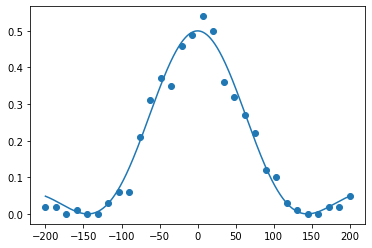

In [21]:
def sampled_lineshape(lineshape_func,
                      delta,
                      tau_pi=6e-3,
                      state_prep=False,
                      samples_per_point=100):
    # quantum jump p from theory
    jump_probabilities = lineshape_func(delta, tau_pi, state_prep)
    # draws from binomial
    measured_results = binom.rvs(n=samples_per_point, p=jump_probabilities)
    sample_shape = measured_results / samples_per_point
    return sample_shape
d = np.linspace(-200, 200, 1000)
d_sample = np.linspace(-200, 200, 30)
s_shape = sampled_lineshape(lineshape, d_sample)
plt.plot(d, lineshape(d, 6e-3, False))
plt.scatter(d_sample, s_shape)

In [ ]:
# main simulation loop with sampled FWHM
n_s = 100 # number of samples
tau_pi = 6e-3 # s, pulse length
T_c = 2*tau_pi # s, single cycle length
T_s = n_s * T_c
initial_offset = 0 # Hz
state_preparation = False
max_tau = 30000 # s, max integration time
n_c = 2 # number of cycles per correction
laser_drift = 20e-3 # Hz/s
f0 = 444779044095486.5 # Hz, Sr88 SRS
t = np.arange(start=T_c, stop=max_tau, step=n_c*T_s)
eta_cavity = np.zeros(len(t)) # cavity frequency
eta_corrected = np.zeros(len(t)) # servo-corrected frequency
d, step = np.linspace(-200, 200, 100000, retstep=True)
kp, _, _ = k_p(lineshape, d, tau_pi)
fwhm = FWHM(lineshape(d, tau_pi), d)
p_X = 0.5 if state_preparation else 0.25
g = -2 * p_X / kp # gain
f_cavity = 0.
f_corrected = initial_offset
for i in range(0, len(t)):
    tau = t[i]
    #print(f)
    p_B, f_corrected, delta_cavity = sampling_cycle(f_corrected, T_s, n_m, fwhm/2., tau_pi=tau_pi, laser_drift=laser_drift)
    f_cavity += delta_cavity
    p_R, f_corrected, delta_cavity = sampling_cycle(f_corrected, T_s, n_m, -fwhm/2., tau_pi=tau_pi, laser_drift=laser_drift)
    f_cavity += delta_cavity
    #print(f"p_R: {p_R}, p_B: {p_B}, without gain: {(p_B - p_R) / (p_B + p_R)}")
    eta_cavity[i] = f_cavity
    E = g * (p_B - p_R) / (p_B + p_R)
    #print(f"Current f offset: {f}; error signal: {E}")
    f_corrected = f_corrected + E
    eta_corrected[i] = f_corrected

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
ax[0].plot(t, eta_corrected)
ax[0].set_ylabel(r"Frequency offset ($f-f_0$)")
ax[0].set_xlabel("t(s)")
ax[1].hist(eta_corrected, density=True)
ax[1].set_xlabel(r"Frequency offset ($f-f_0$)")
(taus, adevs, errors, ns) = allantools.oadev(eta_corrected/f0, data_type='freq', rate=1./(T_s * n_c))
theoretical_adev = allan_deviation(0.25, kp, f0, T_c, taus)
ax[2].scatter(taus, adevs, color='b', marker='x', label="Measured")
ax[2].plot(taus, theoretical_adev, color='r', linestyle='--', label="Theoretical")
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_ylabel(r"Allan deviation $\sigma_y(\tau)$")
ax[2].set_xlabel(r"Integration time $\tau (s)$")
ax[2].legend()
fig.tight_layout()

### Reproducing Dubé2015a

In [145]:
tau_pi = 200e-3 # s, pulse length
T_c = tau_pi + 28e-3 # s, single cycle length
T_s = 8 #s, total sampling time
initial_offset = 0 # Hz
state_preparation = True
max_tau = 1000 # s, max integration time
n_c = 6 # number of cycles per correction
laser_drift = -1e-3 # Hz/s
f0 = 444779044095486.5 # Hz, Sr88 SRS
t = np.arange(start=n_c*T_s, stop=max_tau, step=n_c*T_s)
d, step = np.linspace(-200, 200, 100000, retstep=True)
kp, _, _ = k_p(lineshape, d, tau_pi, state_prep=state_preparation)
fwhm = FWHM(lineshape(d, tau_pi, state_prep=state_preparation), d)
p_X = 0.5 if state_preparation else 0.25
g0 = -2 * p_X / kp # optimal gain
gains = [0.7, 0.85, 1., 1.25, 1.5, 1.9]
eta_theoretical = np.zeros((len(t), len(gains)))
for gi in range(0, len(gains)):
    f_theoretical = np.array([initial_offset] * peaks)
    g = gains[gi]
    for pi in range(peaks):
        for i in range(1, len(t)):
            f_theoretical += laser_drift * n_s * T_c
            p_B0 = lineshape(f_theoretical+fwhm/2., tau_pi, state_preparation)
            p_R0 = lineshape(f_theoretical-fwhm/2., tau_pi, state_preparation)
            E0 = g * g0 * (p_B0 - p_R0) / (p_B0 + p_R0)
            f_theoretical += E0
            eta_theoretical[i, gi] = f_theoretical

In [ ]:
tau_pi = 200e-3 # s, pulse length
T_c = tau_pi + 28e-3 # s, single cycle length
T_s = 8 #s, total sampling time
initial_offset = 0 # Hz
state_preparation = True
max_tau = 1000 # s, max integration time
n_c = 6 # number of cycles per correction
laser_drift = -1e-3 # Hz/s
f0 = 444779044095486.5 # Hz, Sr88 SRS
t = np.arange(start=n_c*T_s, stop=max_tau, step=n_c*T_s)
d, step = np.linspace(-200, 200, 100000, retstep=True)
kp, _, _ = k_p(lineshape, d, tau_pi, state_prep=state_preparation)
fwhm = FWHM(lineshape(d, tau_pi, state_prep=state_preparation), d)
p_X = 0.5 if state_preparation else 0.25
g0 = -2 * p_X / kp # optimal gain
gains = [0.7, 0.85, 1., 1.25, 1.5, 1.9]
eta_theoretical = np.zeros((len(t), len(gains)))
for gi in range(0, len(gains)):
    f_theoretical = initial_offset
    g = gains[gi]
    for i in range(1, len(t)):
            f_theoretical += laser_drift * n_s * T_c
            p_B0 = lineshape(f_theoretical+fwhm/2., tau_pi, state_preparation)
            p_R0 = lineshape(f_theoretical-fwhm/2., tau_pi, state_preparation)
            E0 = g * g0 * (p_B0 - p_R0) / (p_B0 + p_R0)
            f_theoretical += E0
            eta_theoretical[i, gi] = f_theoretical

(-0.02, 0.02)

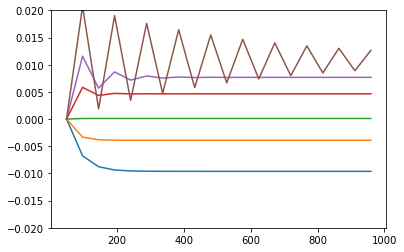

In [146]:
plt.plot(t, eta_theoretical)
plt.ylim([-20e-3, 20e-3])

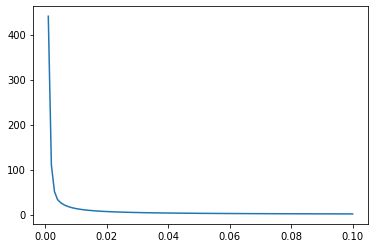

In [118]:
tau_pi = np.linspace(1e-3, 100e-3, 100)
gs = np.zeros(100)
for i in range(len(tau_pi)):
    kp, _, _ = k_p(lineshape, d, tau_pi[i])
    fwhm = FWHM(lineshape(d, tau_pi[i]), d)
    p_X = 0.5 if state_preparation else 0.25
    g = -2 * p_X / kp # gain
    gs[i] = g

plt.plot(tau_pi, gs)

### Laser noise simulation
Cauchy distribution (how to translate into $\Omega_R$-space?), looks ok.

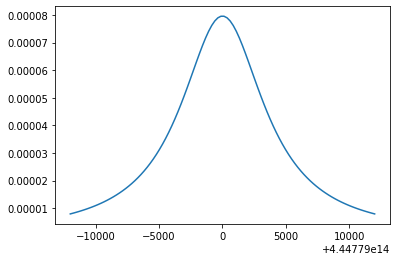

In [282]:
laser_lw = 4e3 #Hz, guess
eta0 = 444.779e12 # transition center
l = np.linspace(eta0 - 3*laser_lw, eta0 + 3*laser_lw, 100)
plt.plot(l, cauchy.pdf(l, loc=eta0, scale=laser_lw))

### Sampling function

(0.02, 252.252351252252)

In [ ]:
# main simulation loop
n_s = 100 # number of samples
tau_pi = 50e-3 # s, pulse length
T_c = tau_pi + 28e-3 # s, single cycle length
T_s = 8 #s, total sampling time
initial_offset = 0 # Hz
state_preparation = True
max_tau = 1000 # s, max integration time
n_c = 6 # number of cycles per correction
laser_drift = -1e-3 # Hz/s
f0 = 444779044095486.5 # Hz, Sr88 SRS
t = np.arange(start=T_c, stop=max_tau, step=n_c*T_s)
d, step = np.linspace(-200, 200, 100000, retstep=True)
kp, _, _ = k_p(lineshape, d, tau_pi, state_prep=state_preparation)
fwhm = FWHM(lineshape(d, tau_pi, state_prep=state_preparation), d)
p_X = 0.5 if state_preparation else 0.25
g0 = -2 * p_X / kp # optimal gain
gains = [0.7, 0.85, 1., 1.25, 1.5, 1.9]
n_mean = 10 # how many complete cycles for sampling cycle
eta_theoretical = np.zeros((len(t), len(gains)))
eta_corrected = np.zeros((len(t), n_mean)) # servo-corrected frequency
eta_mean = np.zeros((len(t), len(gains)))
for gi in range(0, len(gains)):
    for ni in range(0, n_mean):
        f_corrected = initial_offset
        f_theoretical = initial_offset
        for i in range(0, len(t)):
        #    g = gains[gi]
        #    tau = t[i]
        #    p_B, f_corrected, delta_cavity = sampling_cycle(f_corrected, T_s, n_m, fwhm/2., tau_pi=tau_pi, laser_drift=laser_drift, state_prep=state_preparation)
        #    p_R, f_corrected, delta_cavity = sampling_cycle(f_corrected, T_s, n_m, -fwhm/2., tau_pi=tau_pi, laser_drift=laser_drift, state_prep=state_preparation)
        #    E = g * g0 * (p_B - p_R) / (p_B + p_R)
        #    f_corrected += E
        #    eta_corrected[i, ni] = f_corrected
            if(ni==0):
                f_theoretical += laser_drift * n_s * T_c
                p_B0 = lineshape(f_theoretical+fwhm/2., tau_pi, state_preparation)
                p_R0 = lineshape(f_theoretical-fwhm/2., tau_pi, state_preparation)
                E0 = g * g0 * (p_B0 - p_R0) / (p_B0 + p_R0)
                f_theoretical += E0
                eta_theoretical[i, gi] = f_theoretical
    #eta_mean[:, gi] = np.mean(eta_corrected, axis=1)